# Preparation des données
### Initialisation du projet

In [275]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Importation

In [276]:
import os
import pandas as pd

DATASETS_PATH = os.path.join("C:\Development\Projet-IA\datasets")

def load_datasets_data(dataset_path=DATASETS_PATH):
	csv_general = pd.read_csv(os.path.join(dataset_path, "general_data.csv"))
	csv_manager = pd.read_csv(os.path.join(dataset_path, "manager_survey_data.csv"))
	csv_employee = pd.read_csv(os.path.join(dataset_path, "employee_survey_data.csv"))
	csv_intime = pd.read_csv(os.path.join(dataset_path, "in_time.csv"))
	csv_outtime = pd.read_csv(os.path.join(dataset_path, "out_time.csv"))
	return csv_general, csv_manager, csv_employee, csv_intime, csv_outtime

In [277]:
general_set, manager_set, employee_set, intime_set, outtime_set = load_datasets_data()

In [278]:
dataset_merge = general_set.merge(employee_set.merge(manager_set, on="EmployeeID"), on="EmployeeID")
dataset = dataset_merge.copy()

On sépare le code ici car il se bloque si éxécuté en un seul bloc.

### Fusion des données horaire avec le dataset

On importe les données horaires et on les traite puis fusionne avec le dataset complet (general, manager et employés).

In [279]:
#Remplacement des variables NaN en 0
intime_set = intime_set.replace(np.nan, 0)
outtime_set = outtime_set.replace(np.nan, 0)

#Selectione et transformation en format date de la librairie pandas
intime_set.iloc[:, 1:] = intime_set.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
outtime_set.iloc[:, 1:] = outtime_set.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

#On fusionne les deux tableaux (entrée et sortie)
intime_set = intime_set.append(outtime_set)


#On calcule la difference entre l'heure d'entrée et de sortie
intime_set = intime_set.diff(periods=4410)
intime_set = intime_set.iloc[4410:]
intime_set.reset_index(inplace=True)

intime_set.drop(columns=['index', 'Unnamed: 0'],axis=1, inplace=True)
intime_set.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True)

intime_set['Actual Time']=intime_set.mean(axis=1)
intime_set['hrs']=intime_set['Actual Time']/np.timedelta64(1,'h')

C:\Users\Kvendev\AppData\Local\Temp/ipykernel_6848/390643016.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  intime_set.reset_index(inplace=True)


In [280]:
intime_set['hrs']=intime_set['Actual Time']/np.timedelta64(1,'h')
intime_set.reset_index(inplace=True)

# Creation des attributs index et hours (hrs)
intime_set.drop(intime_set.columns.difference(['index','hrs']), 1, inplace=True)
intime_set.rename(columns={'index': 'EmployeeID'}, inplace=True)

#On fusionne notre tableau d'heures avec le dataset global
dataset = dataset.merge(intime_set, on="EmployeeID")

C:\Users\Kvendev\AppData\Local\Temp/ipykernel_6848/3378375524.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  intime_set.drop(intime_set.columns.difference(['index','hrs']), 1, inplace=True)


### ANOVA / KHI2

Le Khi2 (ou Chi2 en anglais et sur python) permet d'avoir une idée des dépendances des variables par rapport à l'attrition.

In [281]:
# KHI2 
import scipy.stats as stats

for name_column in dataset.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(dataset['Attrition'], dataset[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, \
			"\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

BusinessTravel = Statistics :  72.50717871985921 , p_value :  1.7999738337215978e-16 Dépendant
Department = Statistics :  29.075324276447617 , p_value :  4.857060952676939e-07 Dépendant
EducationField = Statistics :  46.18754168561295 , p_value :  8.317648156384632e-09 Dépendant
Gender = Statistics :  1.3624186737962352 , p_value :  0.24311874379456289 Indépendant
JobRole = Statistics :  25.114161989733258 , p_value :  0.00148679389520896 Dépendant
MaritalStatus = Statistics :  138.34881335193026 , p_value :  9.076886223293833e-31 Dépendant
Over18 = Statistics :  0.0 , p_value :  1.0 Indépendant


ANOVA suit le même principe que Khi2 mais calcule différemment.

In [282]:
#ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

for name_column in dataset.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=dataset).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], \
		 "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  114.56435297852201 , p_value :  2.0643297829997614e-26 Dépendant
DistanceFromHome = F :  0.3982188593045061 , p_value :  0.5280432738303005 Indépendant
Education = F :  1.005475682223972 , p_value :  0.3160442234628276 Indépendant
EmployeeCount = F :  1.3944800479765578 , p_value :  0.2377137079477687 Indépendant
EmployeeID = F :  0.09158223883825067 , p_value :  0.7621895039193467 Indépendant
JobLevel = F :  0.4671967642170955 , p_value :  0.494315556720321 Indépendant
MonthlyIncome = F :  4.2938544558653104 , p_value :  0.03830837896884729 Dépendant
NumCompaniesWorked = F :  7.844753196464783 , p_value :  0.0051191555746321225 Dépendant
PercentSalaryHike = F :  4.6451595248508255 , p_value :  0.031195233418440483 Dépendant
StandardHours = F :  1.3944800479765578 , p_value :  0.2377137079477687 Indépendant
StockOptionLevel = F :  0.21180034004505888 , p_value :  0.645382665921585 Indépendant
TotalWorkingYears = F :  131.45193284104118 , p_value :  5.241246810650881e-30 Dépe

### Nettoyage des données / Complétion

#### Catégorisation de l'âge

On catégorise l'age pour que celles-ci

In [283]:
dataset.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,hrs
count,4409.000000,4409.000000,4409.000000,4409.0,4409.000000,4409.000000,4409.000000,4390.000000,4409.000000,4409.0,...,4409.000000,4409.000000,4409.000000,4409.000000,4384.000000,4389.000000,4372.000000,4409.000000,4409.000000,4409.000000
mean,36.923112,9.188251,2.912905,1.0,2205.000000,2.063960,65031.660240,2.695444,15.210252,8.0,...,2.798594,7.004990,2.187571,4.122023,2.723996,2.728184,2.761436,2.729644,3.153776,7.314463
std,9.134220,8.100992,1.024048,0.0,1272.912998,1.106814,47073.969139,2.498840,3.659203,0.0,...,1.288222,6.122203,3.222042,3.566975,1.092571,1.101371,0.706245,0.711223,0.360775,1.330903
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,5.416880
25%,30.000000,2.000000,2.000000,1.0,1103.000000,1.000000,29110.000000,1.000000,12.000000,8.0,...,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,6.278995
50%,36.000000,7.000000,3.000000,1.0,2205.000000,2.000000,49080.000000,2.000000,14.000000,8.0,...,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.011237
75%,43.000000,14.000000,4.000000,1.0,3307.000000,3.000000,83800.000000,4.000000,18.000000,8.0,...,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,7.900932
max,60.000000,29.000000,5.000000,1.0,4409.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.937261


## Test Pipeline	

selection attrition vers y

In [284]:
Attrition = dataset.loc[:, "Attrition"]

In [285]:
dataset_pl = dataset.copy()

useless_value = ['Attrition','StandardHours','EmployeeCount','EmployeeID', "Over18", "Department"] 
dataset_pl = dataset_pl.drop(useless_value, axis=1)

ds_num = dataset_pl.select_dtypes(include=[np.number])
ds_str = dataset_pl.select_dtypes(exclude=[np.number])

In [286]:
num_attribs = list(ds_num)
str_attribs = list(ds_str)

In [287]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(ds_str)

num_pipeline = Pipeline([
	('imputer', SimpleImputer(strategy="median")), 
	('std_scaler', StandardScaler()),			   
])

pipeline = ColumnTransformer([
	("str_vars", encoder, str_attribs),
	("num_vars", num_pipeline, num_attribs)
])

dataset_pipeline = pipeline.fit_transform(dataset_pl, Attrition)
dataset_pipeline

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         3.80171475e-01, -4.26287131e-01,  1.13261739e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.02601647e+00,  2.34583671e+00, -3.74511693e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         3.80171475e-01, -4.26287131e-01, -3.94700539e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.02601647e+00, -4.26287131e-01, -1.23942994e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         3.80171475e-01,  2.34583671e+00,  1.40758587e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.02601647e+00, -4.26287131e-01, -6.03172187e-01]])

In [288]:
dataset_prepared = pd.DataFrame(
    dataset_pipeline,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(str_attribs))))
)

In [289]:
# from sklearn.model_selection import GridSearchCV

# clf_GS = GridSearchCV(pipe, parameters)
# clf_GS.fit(X, y)

In [290]:
# print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
# print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
# print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
# print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

In [291]:
dataset_prepared.describe()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
count,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,...,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03
mean,0.102064,0.188478,0.709458,0.018372,0.412338,0.108188,0.315491,0.055795,0.089816,0.400091,...,-2.963784e-17,5.397512e-17,-1.938924e-17,1.923816e-17,-6.899549e-17,4.231891e-16,2.761582e-16,-1.299835e-16,7.581446e-16,-2.024539e-16
std,0.302767,0.391138,0.454064,0.134306,0.492311,0.310653,0.464764,0.229551,0.285951,0.489972,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.172692e+00,-1.144324e+00,-6.790164e-01,-1.155739e+00,-1.583750e+00,-1.573776e+00,-2.506551e+00,-2.432204e+00,-4.262871e-01,-1.425948e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.199895e-01,-6.542488e-01,-6.790164e-01,-5.949758e-01,-6.659326e-01,-6.637722e-01,-1.085151e+00,-1.026016e+00,-4.262871e-01,-7.781075e-01
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.563620e-01,-3.275320e-01,-3.686190e-01,-3.145944e-01,2.518845e-01,2.462314e-01,3.362485e-01,3.801715e-01,-4.262871e-01,-2.278607e-01
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.563620e-01,3.259017e-01,2.521759e-01,8.069312e-01,1.169702e+00,1.156235e+00,3.362485e-01,3.801715e-01,-4.262871e-01,4.407042e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.485416e+00,5.390013e+00,3.976945e+00,3.610745e+00,1.169702e+00,1.156235e+00,1.757648e+00,1.786359e+00,2.345837e+00,2.722368e+00


### def x,y

In [292]:
y = pd.get_dummies(Attrition, drop_first=True)
x = dataset_prepared

In [293]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4409 non-null   float64
 1   DistanceFromHome                   4409 non-null   float64
 2   Education                          4409 non-null   float64
 3   JobLevel                           4409 non-null   float64
 4   MonthlyIncome                      4409 non-null   float64
 5   NumCompaniesWorked                 4409 non-null   float64
 6   PercentSalaryHike                  4409 non-null   float64
 7   StockOptionLevel                   4409 non-null   float64
 8   TotalWorkingYears                  4409 non-null   float64
 9   TrainingTimesLastYear              4409 non-null   float64
 10  YearsAtCompany                     4409 non-null   float64
 11  YearsSinceLastPromotion            4409 non-null   float

In [294]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

### GridSearch

Definition des hyperparamètres avec GridSearchCV.

In [295]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()

# grid = {"C": np.arange(0.3,0.4,0.01),
#         "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
#         "max_iter": [300,400]
#        }
# classifier_opt = GridSearchCV(lr, grid, scoring = 'accuracy', cv=10)
# classifier_opt.fit(X_train,y_train.values.ravel())
# print("Tuned_parameter k : {}".format(classifier_opt.best_params_))
# print("Best Score: {}".format(classifier_opt.best_score_))


### Regression Logistique

On applique les paramètres trouvés précédemment par GridSearch à la regression logistique.

In [296]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

#"newton-cg", "lbfgs", "liblinear", "sag", "saga"
lr = LogisticRegression(C=0.3, max_iter=300, solver='newton-cg')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test)
dataset.info

<bound method DataFrame.info of       Age Attrition     BusinessTravel              Department  \
0      51        No      Travel_Rarely                   Sales   
1      31       Yes  Travel_Frequently  Research & Development   
2      32        No  Travel_Frequently  Research & Development   
3      38        No         Non-Travel  Research & Development   
4      32        No      Travel_Rarely  Research & Development   
...   ...       ...                ...                     ...   
4404   29        No      Travel_Rarely                   Sales   
4405   42        No      Travel_Rarely  Research & Development   
4406   29        No      Travel_Rarely  Research & Development   
4407   25        No      Travel_Rarely  Research & Development   
4408   42        No      Travel_Rarely                   Sales   

      DistanceFromHome  Education EducationField  EmployeeCount  EmployeeID  \
0                    6          2  Life Sciences              1           1   
1                

In [297]:
print(x)

      Age  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
0     0.0               0.0        1.0       0.0            1.0   
1     0.0               1.0        0.0       0.0            1.0   
2     0.0               1.0        0.0       0.0            0.0   
3     1.0               0.0        0.0       0.0            1.0   
4     0.0               0.0        1.0       0.0            0.0   
...   ...               ...        ...       ...            ...   
4404  0.0               0.0        1.0       0.0            0.0   
4405  0.0               0.0        1.0       0.0            0.0   
4406  0.0               0.0        1.0       0.0            0.0   
4407  0.0               0.0        1.0       0.0            1.0   
4408  0.0               0.0        1.0       0.0            0.0   

      NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
0                    0.0                0.0               0.0   
1                    0.0                0.0               0.0   


[[-0.68343419  0.73236856 -0.04893822  1.07254939 -0.00815729 -0.24955352
  -0.08035514 -0.39743091 -0.33705638 -0.02990151  0.02989766 -0.05281909
  -0.10602389  0.08214561 -0.27420841 -0.48565704  0.54497036  0.17627626
   0.26956347 -0.15425111 -0.4186647  -0.22727442  0.64593527 -0.27227179
  -0.03103516 -0.07565703 -0.05157527 -0.05576925  0.32447096  0.04076766
  -0.08073211 -0.575493   -0.20810611  0.16057071  0.48592158 -0.57907711
  -0.34725482 -0.3611706  -0.24751906 -0.0850542   0.04074726  0.0087775 ]]
Feature: 0, Score: -0.68343
Feature: 1, Score: 0.73237
Feature: 2, Score: -0.04894
Feature: 3, Score: 1.07255
Feature: 4, Score: -0.00816
Feature: 5, Score: -0.24955
Feature: 6, Score: -0.08036
Feature: 7, Score: -0.39743
Feature: 8, Score: -0.33706
Feature: 9, Score: -0.02990
Feature: 10, Score: 0.02990
Feature: 11, Score: -0.05282
Feature: 12, Score: -0.10602
Feature: 13, Score: 0.08215
Feature: 14, Score: -0.27421
Feature: 15, Score: -0.48566
Feature: 16, Score: 0.54497
Fe

K:\Users\Kvendev\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


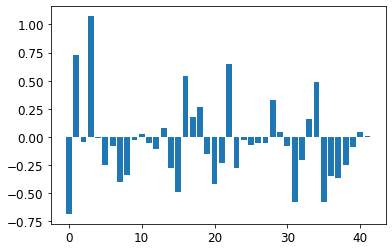

In [298]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

model = LogisticRegression(C=0.3, max_iter=300, solver='newton-cg')

model.fit(x, y)
print(model.coef_)
importance = model.coef_[0]

for i,j in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,j))

pyplot.bar([X for X in range(len(importance))], importance)
pyplot.show()

# Indicateurs de qualité

No handles with labels found to put in legend.


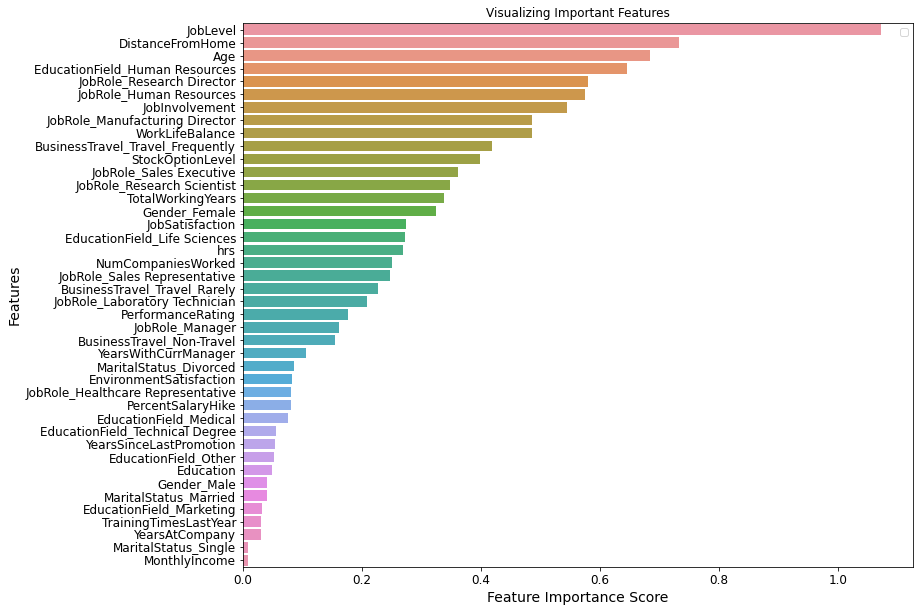

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

importance = abs(model.coef_[0])
feature_imp = pd.Series(importance,index=X_train.columns).sort_values(ascending=False)

# Creating a bar plot
plt.figure(figsize=(12,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Afin de déterminer la qualité de notre regression, nous allonss utiliser les indices suivants :
 - Accuracy
 - Matrice de confusion
 - f1-score
 - Precision/Recall
 - Courbe ROC / AUC (aire sous la courbe)

In [300]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))
print("Matrice de confusion :")
print(confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier on test set: 0.85
Matrice de confusion :
[[1095   15]
 [ 188   25]]


D'après les résultats obtenus, l'Accuracy (ou précision) est de 0.85, c'est à dire que notre modèle va prédire correctement dans 85% des cas.

La matrice de confusion nous sert à déterminer la quantité de vrais et faux positifs, ainsi que les vrais/faux négatifs.

In [301]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1110
           1       0.62      0.12      0.20       213

    accuracy                           0.85      1323
   macro avg       0.74      0.55      0.56      1323
weighted avg       0.82      0.85      0.80      1323



In [302]:
corrmat = X_train.corr() 
corrdf = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))
corrdf = corrdf.unstack().reset_index()
corrdf.columns = ['Var1', 'Var2', 'Correlation']
corrdf.dropna(subset = ['Correlation'], inplace = True)
corrdf['Correlation'] = round(corrdf['Correlation'], 2)
corrdf['Correlation'] = abs(corrdf['Correlation'])
matrix= corrdf.sort_values(by = 'Correlation', ascending = False).head(50)
matrix

C:\Users\Kvendev\AppData\Local\Temp/ipykernel_6848/2583708761.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corrdf = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))


,Var1,Var2,Correlation
429,YearsAtCompany,TrainingTimesLastYear,1.00
1709,MaritalStatus_Married,Gender_Male,0.78
1503,JobRole_Research Director,JobRole_Manager,0.77
85,Education,DistanceFromHome,0.75
1325,JobRole_Human Resources,EducationField_Life Sciences,0.69
945,EducationField_Human Resources,BusinessTravel_Travel_Rarely,0.63
1461,JobRole_Manufacturing Director,JobRole_Manager,0.62
1417,JobRole_Manager,JobRole_Human Resources,0.62
256,PercentSalaryHike,MonthlyIncome,0.57
84,Education,Age,0.53


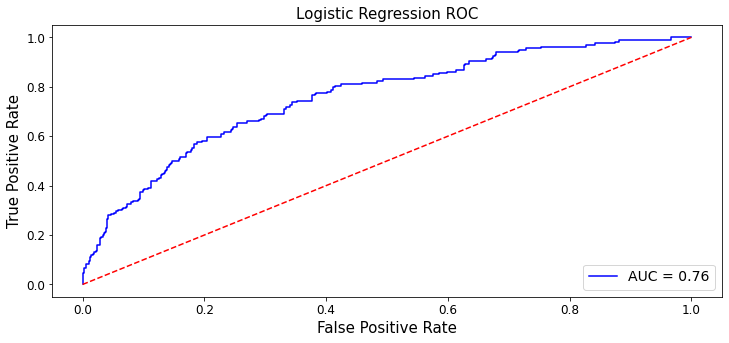

In [303]:
from sklearn import metrics

plt.figure(figsize=(12,5))

lrprob = lr.predict_proba(X_test)
lr_pred = lrprob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Logistic Regression ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()
